[*********************100%%**********************]  1 of 1 completed


Best parameters: atr_period=47, multiplier=6.599840849810309
Best portfolio value: 141180.99822998047


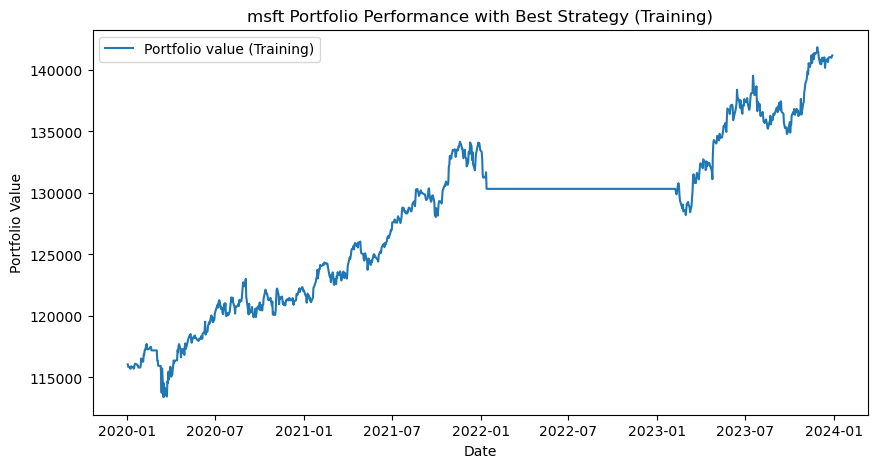

[*********************100%%**********************]  1 of 1 completed


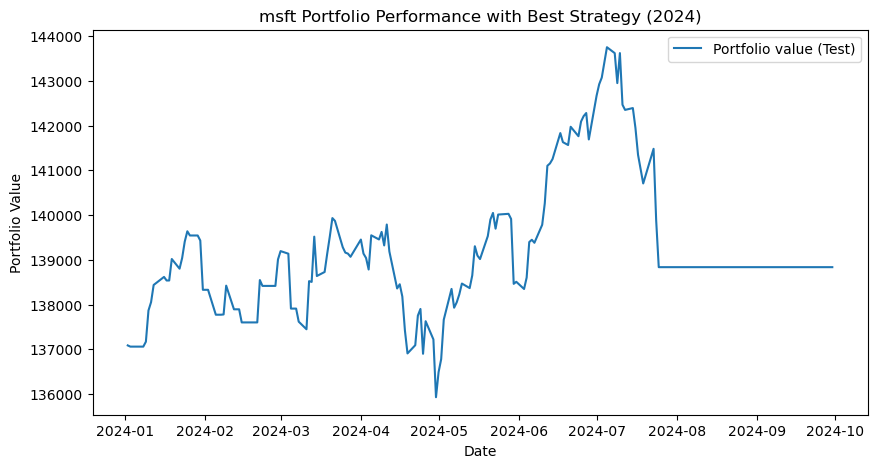

Final portfolio value: 138835.99853515625


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from deap import base, creator, tools, algorithms
import ta
import warnings

warnings.filterwarnings('ignore')

ticker = 'msft'
namme = ticker
data = yf.download(ticker, start='2020-01-01', end='2024-01-01')
data['Date'] = data.index

def supertrend_strategy(data, atr_period, multiplier):
    df = data.copy()
    df['atr'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=atr_period).average_true_range()
    df['upperband'] = ((df['High'] + df['Low']) / 2) + (multiplier * df['atr'])
    df['lowerband'] = ((df['High'] + df['Low']) / 2) - (multiplier * df['atr'])
    df['in_uptrend'] = True

    for current in range(1, len(df.index)):
        previous = current - 1

        if df['Close'][current] > df['upperband'][previous]:
            df['in_uptrend'][current] = True
        elif df['Close'][current] < df['lowerband'][previous]:
            df['in_uptrend'][current] = False
        else:
            df['in_uptrend'][current] = df['in_uptrend'][previous]

            if df['in_uptrend'][current] and df['lowerband'][current] < df['lowerband'][previous]:
                df['lowerband'][current] = df['lowerband'][previous]

            if not df['in_uptrend'][current] and df['upperband'][current] > df['upperband'][previous]:
                df['upperband'][current] = df['upperband'][previous]

    df['signal'] = np.where(df['in_uptrend'], 1.0, 0.0)
    df['positions'] = df['signal'].diff()
    return df

def evaluate_strategy(signals):
    initial_capital = 100000.0
    positions = pd.DataFrame(index=signals.index).fillna(0.0)
    positions['gold'] = 100 * signals['signal']
    portfolio = positions.multiply(signals['Close'], axis=0)
    pos_diff = positions.diff()
    portfolio['holdings'] = (positions.multiply(signals['Close'], axis=0)).sum(axis=1)
    portfolio['cash'] = initial_capital - (pos_diff.multiply(signals['Close'], axis=0)).sum(axis=1).cumsum()
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    portfolio['returns'] = portfolio['total'].pct_change()
    return portfolio

def evaluate_individual(individual):
    atr_period, multiplier = int(individual[0]), individual[1]
    signals = supertrend_strategy(data, atr_period, multiplier)
    portfolio = evaluate_strategy(signals)
    return (-portfolio['total'].iloc[-1],)  # Return a tuple

# Genetic Algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_int", np.random.randint, 1, 50)
toolbox.register("attr_float", np.random.uniform, 1, 10)
toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_int, toolbox.attr_float), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)

def mutPolynomialBoundedReal(individual, eta, low, up, indpb):
    size = len(individual)
    for i in range(size):
        if np.random.random() <= indpb:
            x = individual[i]
            xl = low[i]
            xu = up[i]
            if x < xl or x > xu:
                x = xl + (xu - xl) * np.random.random()
            delta_1 = (x - xl) / (xu - xl)
            delta_2 = (xu - x) / (xu - xl)
            rand = np.random.random()
            mut_pow = 1.0 / (eta + 1.)
            if rand < 0.5:
                xy = 1.0 - delta_1
                val = 2.0 * rand + (1.0 - 2.0 * rand) * (xy ** (eta + 1))
                delta_q = val ** mut_pow - 1.0
            else:
                xy = 1.0 - delta_2
                val = 2.0 * (1.0 - rand) + 2.0 * (rand - 0.5) * (xy ** (eta + 1))
                delta_q = 1.0 - val ** mut_pow
            x = x + delta_q * (xu - xl)
            x = min(max(x, xl), xu)
            individual[i] = x.real  # Ensure the value is real
    return individual,

toolbox.register("mutate", mutPolynomialBoundedReal, low=[1, 1], up=[50, 10], eta=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate_individual)

population = toolbox.population(n=50)
ngen = 10
cxpb = 0.5
mutpb = 0.2

result, log = algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, verbose=False)

best_individual = tools.selBest(result, k=1)[0]
print(f'Best parameters: atr_period={int(best_individual[0])}, multiplier={best_individual[1]}')
print(f'Best portfolio value: {-best_individual.fitness.values[0]}')

signals = supertrend_strategy(data, int(best_individual[0]), best_individual[1])
portfolio = evaluate_strategy(signals)

plt.figure(figsize=(10, 5))
plt.plot(portfolio['total'], label='Portfolio value (Training)')
plt.title(f'{namme} Portfolio Performance with Best Strategy (Training)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

new_data = yf.download(ticker, start='2024-01-01', end='2024-12-31')
new_data['Date'] = new_data.index

signals = supertrend_strategy(new_data, int(best_individual[0]), best_individual[1])
portfolio = evaluate_strategy(signals)

plt.figure(figsize=(10, 5))
plt.plot(portfolio['total'], label='Portfolio value (Test)')
plt.title(f'{namme} Portfolio Performance with Best Strategy (2024)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

print(f'Final portfolio value: {portfolio["total"].iloc[-1]}')
